In [68]:
# import of necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from cmdstanpy import CmdStanModel

pd.options.mode.chained_assignment = None


In [2]:
# load data
df = pd.read_csv('data/high_diamond_ranked_10min.csv')

### 1. Problem Formulation

The objective of this project is to develop a Bayesian predictive model for League of Legends (LoL) games. LoL is a popular multiplayer online battle arena (MOBA) game developed and published by Riot Games. In this game, two teams (blue and red one) of five players compete against each other in an effort to destroy the opponent's Nexus - the core building located in the heart of the opposing team's base.

As the problem requires some expert knowledge, therefore we provide brief summary of LoL game rules and features necessary that we believe that are necessary to understand the analysis.

- Gold: In LoL, gold is the primary resource used to purchase items. Items can enhance a champion's stats, grant them new abilities, and generally make them more powerful. Players earn gold in a variety of ways, including killing enemy champions, minions, and neutral monsters, and destroying enemy structures.

- Experience (XP): Experience points, or XP, is another crucial resource in the game. Players earn XP by being near enemy minions or monsters when they die, or by killing or assisting in killing enemy champions. When a champion earns enough XP, they level up, increasing their base stats and allowing them to unlock or upgrade one of their abilities.

- Kills: A kill is awarded to a player when they land the final blow that results in the death of an enemy champion.

- Assists: An assist is awarded to a player if they contributed to the death of an enemy champion but did not land the final blow. Assists still grant gold and experience, albeit less than kills.

- Deaths: A death occurs when a champion's health reaches zero. Upon death, a champion respawns back at their base after a certain amount of time, which increases as the game progresses.

- Epic Monsters: Epic monsters are powerful neutral creatures that provide significant benefits when killed. They include the Dragon, Baron Nashor, and Rift Herald. Killing these monsters grants the team various buffs, bonus gold, and experience.

- Towers: Towers, also known as turrets, are powerful defensive structures that guard the three main paths (or lanes) to each team's base. They attack enemy champions and minions that come within range and provide a significant obstacle to attacking teams. Destroying a tower grants gold to the team and pushes the lane closer to the enemy base.

- Minions: Minions are AI-controlled units that spawn at the nexus and advance along the three lanes toward the enemy base. They attack enemy champions, minions, and towers, and killing them provides gold and experience. The constant flow of minions is a primary mechanism driving the game forward and forcing player interaction.


We assume that the games are independent of each other. That is, the outcome of a game only depends on the statistics of that game and not any other games.
We are ignoring in-game factors that could change over time, such as patch updates, new champion releases, etc., which could affect the game's outcome.

**The aim of the project is to predict the result (winner) of the game based on statistics of each team after 10 minutes of the game.**

We claim our model may be useful. Predicted **use-cases** of proposed model are desbribed below.

- E-Sports Betting This model could be used by individuals involved in e-sports betting to better predict game outcomes and make more informed bets.

- Performance Analysis Teams could use this analysis to identify what factors in the first 10 minutes of a game are most predictive of success. This can guide their training and strategies for future games.

- Player Improvement Individual players could use this analysis to understand what factors in the first 10 minutes of a game are important for winning, allowing them to improve their gameplay.

- Game Development For the game developers, these insights could guide balanced gameplay, champion design, and other game development decisions. They could use this to identify if early game events are disproportionately affecting the game's outcome and need to be rebalanced.

**Data source.**

Data has been downloaded from kaggle. 

https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min  

Dataset cosist of 40 columns and 9879 rows.

Exact column names are depicted in section 1.1.

Beside gameId and result (Blue wins) all collumns are divided into statistics of opposite teams: blue and red ones.
Distinc features describe:

- wards (blueWins, blueWardsPlaced, blueWardsDestroyed) - we do not use this data in further analysis

- kills deaths, asists

- structures destroyed

- gold related stats

- experience related stats

- etc.

**DAG** is depicted in section 1.2.

**Cofoundings**

Pipes (Causal Chains):

- epicMonstersDifference -> experienceDifference -> gameResult
- epicMonstersDifference -> goldDifference -> gameResult
- minionsDifference -> experienceDifference -> gameResult
- minionsDifference -> goldDifference -> gameResult
- towersDifference -> goldDifference -> gameResult
- DAKDA -> experienceDifference -> gameResult
- DAKDA -> goldDifference -> gameResult

Forks (Common Cause):

- epicMonstersDifference causing changes in experienceDifference and goldDifference.
- minionsDifference causing changes in experienceDifference and goldDifference.
- DAKDA causing changes in experienceDifference and goldDifference.

Colliders (Common Effect):

- experienceDifference and goldDifference both causing changes in gameResult.


#### EDA

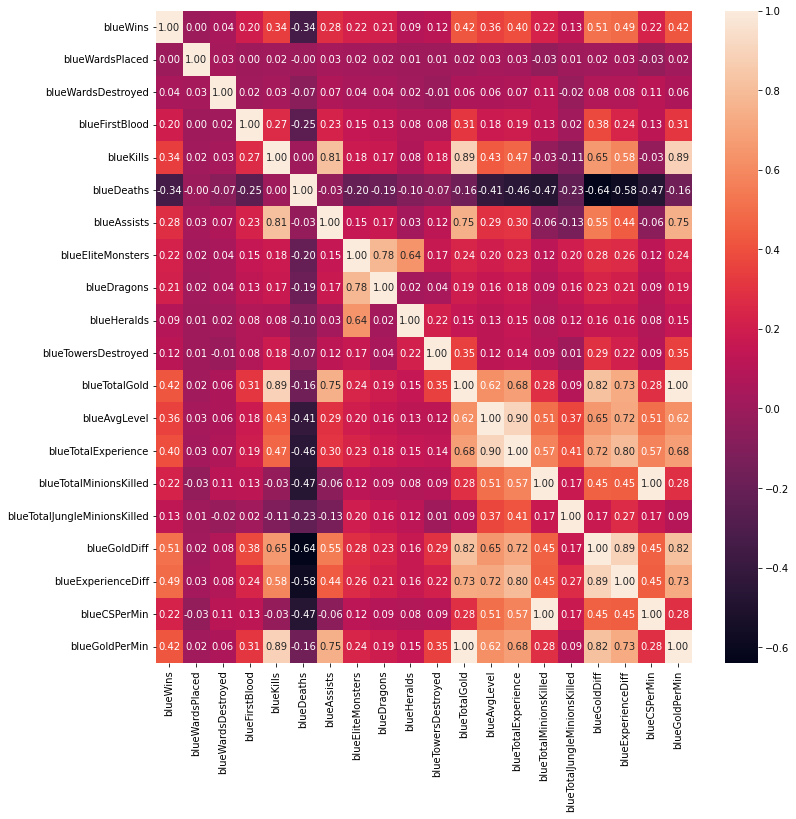

In [3]:
onlyBlueCols = [c for c in df.columns if 'blue' in c.lower()]
plt.figure(figsize=(12, 12))
sns.heatmap(df[onlyBlueCols].corr(), annot=True, fmt=".2f")
plt.show()

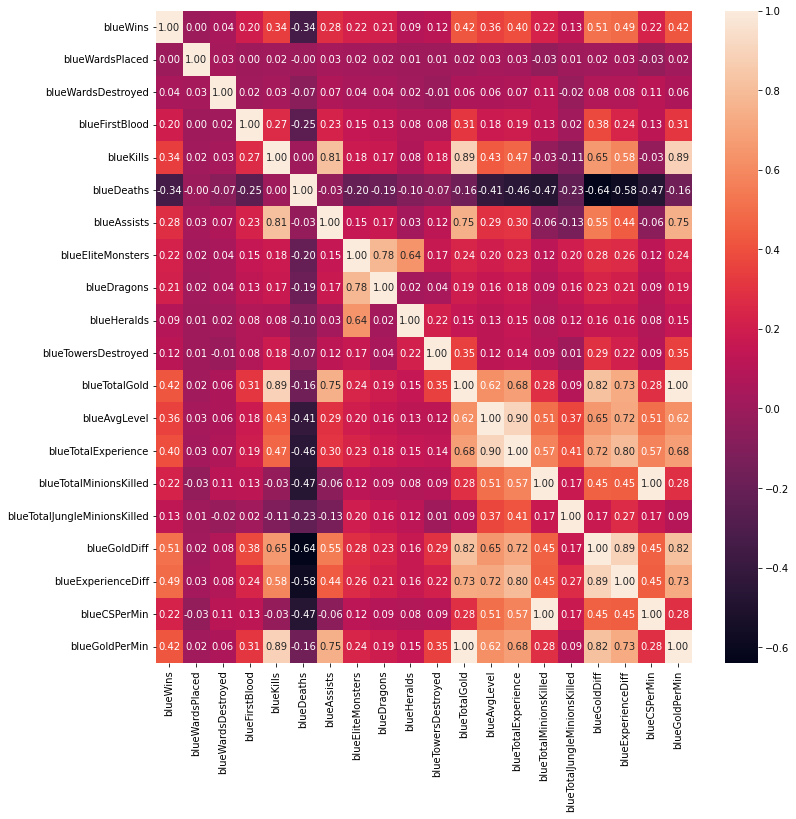

In [4]:
plt.figure(figsize=(12, 12))
sns.heatmap(df[onlyBlueCols].corr(), annot=True, fmt=".2f")
plt.show()

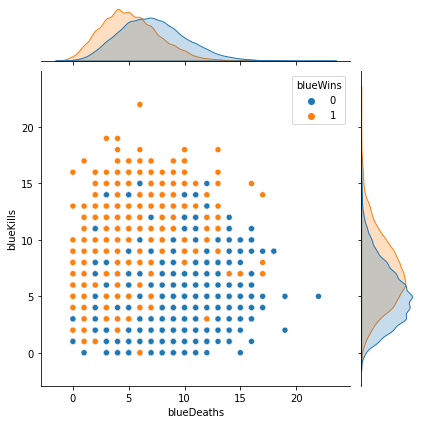

In [5]:
sns.jointplot(data=df, x="blueDeaths", y="blueKills", hue="blueWins")
plt.show()

#### 1.1

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

#### 1.2 DAG

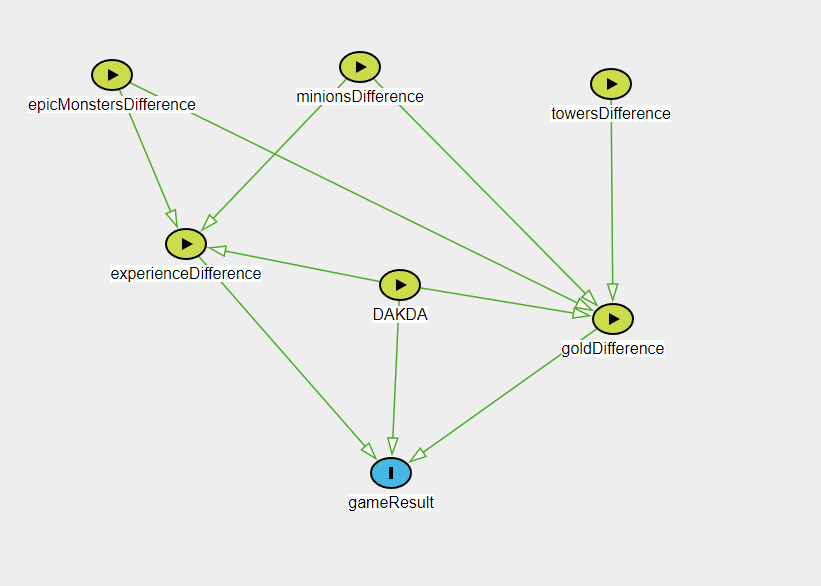

### 2. Data Preprocessing

We have dropped all the rows what contained NaNs (0).

We conclued that in game it does not matter whether team is good by any measure but the difference in these features is what matters the most, therefore we made features differential. This process code is provided in section 2.1.

Our Bayesian model will incorporate the following difference variables, comparing the stats of both teams:

Team Gold Difference: The difference in the total amount of gold earned by each team. Gold is earned by killing enemy champions, minions, and neutral monsters and is used to buy items to strengthen champions.

Team Experience Difference: The difference in total experience points earned by each team. Experience points are crucial for leveling up the champions and unlocking and strengthening their abilities.

Difference Augmented KDA: KDA stands for Kills, Deaths, and Assists. We'll look at the difference between the KDA ratios of each team, a measure of overall team performance in fights.

Minions Difference: The difference in the total number of minions (non-player characters that are a primary source of gold and experience) killed by each team.

Epic Monster Difference: The difference in the number of epic monsters (highly powerful neutral monsters that grant significant benefits when killed) each team has slain.

Towers Destroyed Difference: The difference in the number of towers (defensive structures that guard the main paths towards the nexus) each team has destroyed.

These difference variables provide a quantifiable measure of each team's advantage over the other after the first 10 minutes of the game, which we can use to predict the eventual game outcome.


We scale data (subtract mean and divide by std) as we came across issues HMC sampler convergence. Exact code can be found in secion 2.2.



#### 2.1

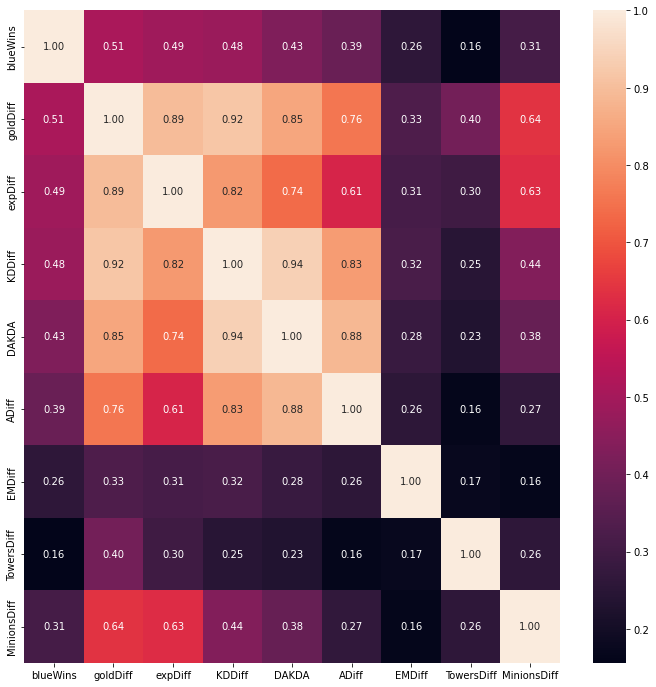

In [7]:
features = df[['blueWins']]

features["goldDiff"] = df["blueGoldDiff"]
features["expDiff"] = df["blueExperienceDiff"]
features["KDDiff"] = df["blueKills"] - df["blueDeaths"]
features["DAKDA"] = (df["blueKills"] + df["blueAssists"]) * df["redDeaths"] - (df["redKills"] + df["redAssists"]) * df["blueDeaths"]
features["ADiff"] = df["blueAssists"] - df["redAssists"]
features["EMDiff"] = df["blueEliteMonsters"] - df["redEliteMonsters"]
features["TowersDiff"] = df["blueTowersDestroyed"] - df["redTowersDestroyed"]
features["MinionsDiff"] = df["blueTotalMinionsKilled"] - df["redTotalMinionsKilled"]

plt.figure(figsize=(12, 12))
sns.heatmap(features.corr(), annot=True, fmt=".2f")
plt.show()

#### 2.2

In [8]:
scaler = StandardScaler()

X = features[['goldDiff', 'expDiff']]
y = features['blueWins'].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=28062023)

scaler.fit(X_train)
X_train = scaler.transform(X_train)

#### EDA

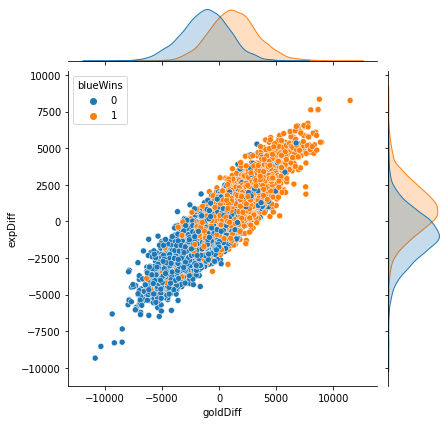

In [105]:
sns.jointplot(data=features, x="goldDiff", y="expDiff", hue="blueWins")
plt.show()

### 3. Model


#### First Model (Logit Model)

The model have two distinct predictors:

$$ x = [goldDiff, expDiff]^{T} $$

$$ \beta = [\beta_{goldDiff}, \beta_{expDiff}]^{T} $$

$\alpha$ is a scalar variable.

$$ y = log(\frac{\alpha + \beta^{T}x}{1 + \alpha + \beta^{T}x}) $$

Here we provide code of first model:

```stan
data {
  int<lower=0> N;
  real goldDiff[N];
  real expDiff[N];
  int<lower=0, upper=1> gameWon[N]; 
}

parameters {
  real alpha;
  real beta_gold;
  real beta_exp;
}

transformed parameters {
  vector[N] eta;
  for (n in 1:N) {
    eta[n] = alpha + beta_gold * goldDiff[n] + beta_exp * expDiff[n];
  }
  vector[N] p;
  p = inv_logit(eta);
}

model {
  alpha ~ normal(0, 1);
  beta_gold ~ normal(0, 1);
  beta_exp ~ normal(0, 1);

  for (n in 1:N) {
    gameWon[n] ~ bernoulli(p[n]);
  }
}

generated quantities {
  vector[N] log_lik;
  int gameWon_pred[N];  

  for (n in 1:N) {
    log_lik[n] = bernoulli_lpmf(gameWon[n]| p[n]);
    gameWon_pred[n] = bernoulli_rng(p[n]);
  }
}
```

#### Second Model (Probit Model)

$$  x = [DAKDA, epicMonstersDiff, minionsDiff, towersDiff, goldDiff, expDiff]^T $$

$$ \beta = [ \beta{DAKDA}, \beta{epicMonstersDiff}, \beta{minionsDiff}, \beta{towersDiff}, \beta{goldDiff}, \beta{expDiff}]^T$$

$$ y = \int_{-\infty}^{\alpha + \beta^T x} normal(z|\mu=0, \sigma=1) dz$$


```stan
data {
  int<lower=0> N; 
  real DAKDA[N];
  real EMDiff[N];
  real minionsDiff[N];
  real towersDiff[N];
  real goldDiff[N];
  real expDiff[N];
  int<lower=0, upper=1> gameWon[N]; 
}

parameters {
  real alpha;
  real beta_gold;
  real beta_exp;
  real beta_dakda;
  real beta_em;
  real beta_minions;
  real beta_towers;
}

transformed parameters {
  vector[N] eta;
  for (n in 1:N) {
    eta[n] = alpha + beta_gold * goldDiff[n] + beta_exp * expDiff[n] + beta_dakda * DAKDA[n] + beta_em * EMDiff[n] + beta_minions * minionsDiff[n] + beta_towers * towersDiff[n];
  }
  vector[N] p;
  p = Phi(eta);
}

model {
  alpha ~ normal(0, 1);
  beta_gold ~ normal(0, 1);
  beta_exp ~ normal(0, 1);
  beta_dakda ~ normal(0, 1);
  beta_em ~ normal(0, 1);
  beta_minions ~ normal(0, 1);
  beta_towers ~ normal(0, 1);

  for (n in 1:N) {
    gameWon[n] ~ bernoulli(p[n]);
  }
}

generated quantities {
  vector[N] log_lik;
  int<lower=0, upper=1> gameWon_pred[N];
  for (n in 1:N) {
    real eta = alpha + beta_gold * goldDiff[n] + beta_exp * expDiff[n] + beta_dakda * DAKDA[n] + beta_em * EMDiff[n] + beta_minions * minionsDiff[n] + beta_towers * towersDiff[n];
    real p = Phi(eta);
    log_lik[n] = bernoulli_lpmf(gameWon[n]| p);
    gameWon_pred[n] = bernoulli_rng(p);
  }
}
```

#### Difference between models and justification of adding new features

The first model is a simple logit regression that utilizes the most important two features: Gold Difference and Experience Difference. We want to have a base line upon which we could improve in the second model.

The second model uses four additional features that are more specific to in-game mechanics i.e. Epic Monster DIfference, Minions Difference, Towers Difference, DAKDA. It also sports a probit link function instead of the logit one.

We are not satified with the results of the presented model, accuracy is slightly above 0.72. We conclue from EDA that two chosen features are not sufficent to linearly separate the won and lost games. We utilize additional features to enhance the performance of a model.

#### Inference details

Models return a real number $x$ between 0. and 1. that describes the probability of a game to result in a win.

The inferrence is done using the formula defined below:
$$
\text{gameResult} = 
\begin{cases} 
\text{win} & \text{if } x > 0.5, \\
\text{lose} & \text{otherwise}.
\end{cases}
$$

### 4. Priors

The priors for the parameters were set to be a weakly informative standard normal distributions, since we have encountered sampling issues with the posterior models that were solved by standard scaling the data. 

$$\alpha \sim \mathcal{N}(0,1)$$
$$\beta \sim \mathcal{N}(0,1)$$

The priors for the measurements (observables) were assigned to follow uniform distributions in the range from -5 to 5, where we know the values should lie after the standard scaling is applied. We believe this is reasonable because that allows our model to be checked in the possible range of the data without neccessarily relying on the exact distribution of the data.

$$  measurements \sim \mathcal{U}(-5,5) $$


#### Prior predictive checks for logit model:
```stan
generated quantities {
  real alpha = normal_rng(0, 1);
  real beta_gold = normal_rng(0, 1);
  real beta_exp = normal_rng(0, 1);

  // the data is normalized, so I expect the values to lie between -5 and 5
  real goldDiff = uniform_rng(-5, 5); 
  real expDiff = uniform_rng(-5, 5);
  
  real eta = alpha + beta_gold * goldDiff + beta_exp * expDiff;
  real p = inv_logit(eta); 
  
  int <lower=0, upper=1> gameWon_pred = bernoulli_rng(p); 
}
```

In [72]:
logit_ppc = CmdStanModel(stan_file='models/logit_ppc.stan')

17:20:56 - cmdstanpy - INFO - compiling stan file /home/models/logit_ppc.stan to exe file /home/models/logit_ppc
17:21:03 - cmdstanpy - INFO - compiled model executable: /home/models/logit_ppc


In [73]:
logit_ppc_data = logit_ppc.sample(iter_sampling=100)

17:21:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:21:03 - cmdstanpy - INFO - CmdStan done processing.


In [74]:
az.summary(logit_ppc_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.036,0.980,-1.556,1.995,0.047,0.033,436.0,408.0,1.00
beta_gold,-0.010,1.023,-1.718,2.098,0.054,0.038,366.0,374.0,1.00
beta_exp,-0.033,1.082,-1.748,2.164,0.056,0.040,369.0,353.0,1.00
goldDiff,-0.063,2.905,-4.821,4.498,0.148,0.111,395.0,402.0,1.02
expDiff,0.033,2.897,-4.566,4.668,0.132,0.105,513.0,466.0,1.00
eta,-0.177,4.504,-8.542,9.396,0.199,0.169,513.0,414.0,1.00
p,0.498,0.394,0.000,0.999,0.018,0.013,512.0,414.0,1.00
gameWon_pred,0.518,0.500,0.000,1.000,0.024,0.017,445.0,400.0,1.01


In [75]:
logit_ppc_df = logit_ppc_data.draws_pd()

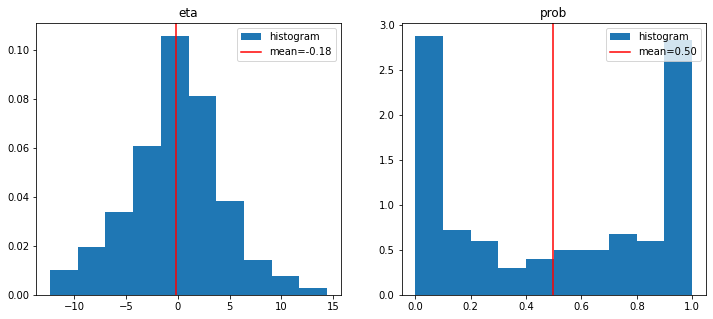

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(logit_ppc_df.eta, bins=10, density=True, label='histogram')
mean = logit_ppc_df.eta.mean()
axes[0].axvline(mean, c="r", label=f'{mean=:.2f}')
axes[0].legend()
axes[0].set_title("eta")

axes[1].hist(logit_ppc_df.p, bins=10, density=True, label='histogram')
mean = logit_ppc_df.p.mean()
axes[1].axvline(mean, c="r", label=f'{mean=:.2f}')
axes[1].legend()
axes[1].set_title("prob")

plt.show()

The priors for the parameters and measurements appear to generate reasonable distributions of **eta** and **prob**, which should allow the model to flexibly adapt to the data. That can be concluded from a wider spread in the eta parameter and heavy tails in the distribution of prob.

#### Prior predictive checks for probit model:
```stan
generated quantities {
  real alpha = normal_rng(0, 1);
  real beta_gold = normal_rng(0, 1);
  real beta_exp = normal_rng(0, 1);
  real beta_dakda = normal_rng(0, 1);
  real beta_em = normal_rng(0, 1);
  real beta_minions = normal_rng(0, 1);
  real beta_towers = normal_rng(0, 1);

  // variables are normalized, so I expect the values to lie between -5 and 5
  real goldDiff = uniform_rng(-5, 5); 
  real expDiff = uniform_rng(-5, 5);
  real DAKDA = uniform_rng(-5, 5);
  real minionsDiff = uniform_rng(-5, 5);
  real EMDiff = uniform_rng(-5, 5);
  real towersDiff = uniform_rng(-5, 5);
  
  real eta = alpha + beta_gold * goldDiff + beta_exp * expDiff + beta_dakda * DAKDA + beta_em * EMDiff + beta_minions * minionsDiff + beta_towers * towersDiff;
  real p = Phi(eta);
  
  int <lower=0, upper=1> gameWon_pred = bernoulli_rng(p); 
}
```

In [184]:
probit_ppc = CmdStanModel(stan_file='models/probit_ppc.stan')

17:58:34 - cmdstanpy - INFO - compiling stan file /home/models/probit_ppc.stan to exe file /home/models/probit_ppc
17:58:40 - cmdstanpy - INFO - compiled model executable: /home/models/probit_ppc


In [185]:
probit_ppc_data = probit_ppc.sample(iter_sampling=100)

17:58:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:58:41 - cmdstanpy - INFO - CmdStan done processing.


In [186]:
az.summary(probit_ppc_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.031,0.981,-1.880,1.751,0.052,0.042,353.0,363.0,1.01
beta_gold,-0.013,1.071,-1.913,2.153,0.051,0.039,431.0,312.0,1.00
beta_exp,0.027,1.001,-1.706,1.909,0.058,0.041,307.0,361.0,1.00
beta_dakda,0.064,0.975,-1.652,1.951,0.046,0.034,444.0,397.0,1.00
beta_em,-0.032,0.996,-1.753,1.818,0.047,0.037,451.0,410.0,1.00
beta_minions,0.011,0.976,-1.743,1.826,0.057,0.041,291.0,263.0,1.00
beta_towers,0.002,0.983,-1.831,1.729,0.046,0.034,453.0,448.0,1.00
goldDiff,-0.014,2.941,-4.656,4.711,0.148,0.115,413.0,357.0,1.00
expDiff,0.053,2.945,-4.500,4.855,0.145,0.103,416.0,447.0,1.00
DAKDA,-0.093,2.825,-4.777,4.456,0.149,0.106,376.0,414.0,1.00


In [187]:
probit_ppc_df = probit_ppc_data.draws_pd()

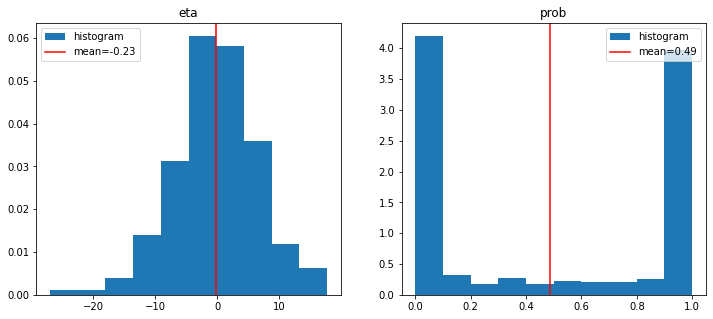

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(probit_ppc_df.eta, bins=10, density=True, label='histogram')
mean = probit_ppc_df.eta.mean()
axes[0].axvline(mean, c="r", label=f'{mean=:.2f}')
axes[0].legend()
axes[0].set_title("eta")

axes[1].hist(probit_ppc_df.p, bins=10, density=True, label='histogram')
mean = probit_ppc_df.p.mean()
axes[1].axvline(mean, c="r", label=f'{mean=:.2f}')
axes[1].legend()
axes[1].set_title("prob")

plt.show()

Just like in the prior predictive check for the logit model we have a wide distribution of eta. The introduction of additional parameters allows the model to distinguish between the two classes more effectively.

### 5. Posterior analysis First Model

#### Issues with sampling

In our initial approach, we used centered data for our models. However, we soon encountered issues related to sampling. Upon investigating potential root causes, we discovered that the substantial variability in the range of values across different features was complicating the efficiency and accuracy of the Hamiltonian Monte Carlo (HMC) sampling process.

The HMC sampler uses gradient information to adaptively sample from the target distribution. When there's a wide range of values across different features, it effectively increases the dimensionality of the search space, leading to potential issues such as the "curse of dimensionality". This, in turn, can cause the HMC sampler to struggle with exploration, often resulting in divergence warnings.

As a remedy, we decided to standardize the data, which means we rescaled our features to have a mean of 0 and a standard deviation of 1. This process unifies the spread of values, therefore restricting the dimensionality of the search space and improving the performance of the HMC sampler. Standardization of data can aid in better exploration of the parameter space, thereby potentially mitigating divergence issues and improving the overall efficiency of the sampling process.

In [77]:
logit_posterior = CmdStanModel(stan_file='models/logit_posterior.stan')

17:21:22 - cmdstanpy - INFO - compiling stan file /home/models/logit_posterior.stan to exe file /home/models/logit_posterior
17:21:30 - cmdstanpy - INFO - compiled model executable: /home/models/logit_posterior
17:21:30 - cmdstanpy - WARNING - Stan compiler has produced 4 warnings:
17:21:30 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/models/logit_posterior.hpp /home/models/logit_posterior.stan
Warning in '/home/models/logit_posterior.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/models/logit_posterior.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This c

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = features[['goldDiff', 'expDiff']]
y = features['blueWins'].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=28062023)

scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [79]:
data = {
    'N': len(y_train),
    'gameWon': y_train,
    'goldDiff': X_train[:, 0],
    'expDiff': X_train[:, 1]
}

fit_logit = logit_posterior.sample(data=data, iter_warmup=100, iter_sampling=100, seed=28062023)

17:21:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:21:33 - cmdstanpy - INFO - CmdStan done processing.


In [80]:
logit_posterior_df = fit_logit.draws_pd()

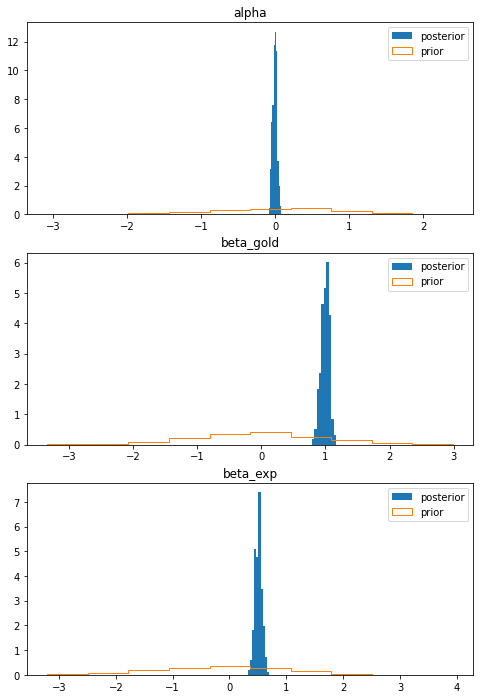

In [82]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes = axes.flatten()
for i, param in enumerate(("alpha", "beta_gold", "beta_exp")):
    axes[i].hist(logit_posterior_df[param], bins=10, label="posterior", density=True)
    axes[i].hist(logit_ppc_df[param], bins=10, histtype='step', label="prior", density=True)
    axes[i].set_title(param)
    axes[i].legend()

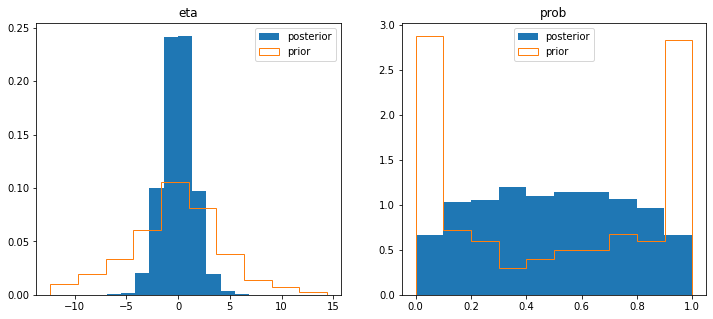

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

posterior_etas = logit_posterior_df.loc[:, "eta[1]":f"eta[{len(y_train)}]"].mean()

axes[0].hist(posterior_etas, bins=10, density=True, label='posterior')
axes[0].hist(logit_ppc_df.eta, bins=10, density=True, histtype='step', label="prior")
axes[0].legend()
axes[0].set_title("eta")

posterior_probs = logit_posterior_df.loc[:, "p[1]":f"p[{len(y_train)}]"].mean()

axes[1].hist(posterior_probs, bins=10, density=True, label='posterior')
axes[1].hist(logit_ppc_df.p, bins=10, density=True, histtype='step', label="prior")
axes[1].legend()
axes[1].set_title("prob")

plt.show()

We have compared the distributions of the parameters from prior and posterior predictive checks. The histograms are concentrated around specific values. In the posterior distributions the ranges have been limited by fitting to the data. The values have been greatly narrowed down after taking data into account.

#### Jointplot of the data

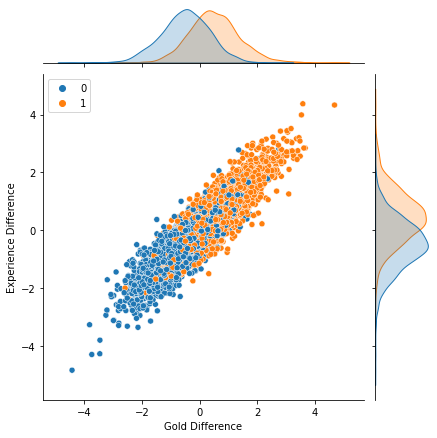

In [224]:
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train)
plt.xlabel("Gold Difference")
plt.ylabel("Experience Difference")
plt.show()

#### Jointplot of the samples

In [220]:
logit_sample_results = (logit_posterior_df.loc[:, "gameWon_pred[1]":f"gameWon_pred[{len(y_train)}]"].mean() > 0.5).astype(int)

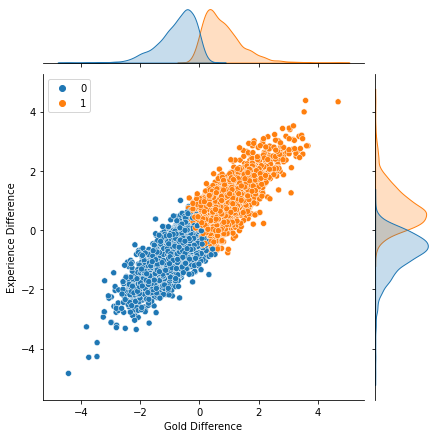

In [225]:
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], hue=logit_sample_results)
plt.xlabel("Gold Difference")
plt.ylabel("Experience Difference")
plt.show()

The samples are mostly consistent with the data, but since the model is a linear model with two features it appears to not capture the instances that are not linearly separable.

#### Inference

In [109]:
alpha = logit_posterior_df.alpha.mean()
beta = logit_posterior_df.loc[:, "beta_gold":"beta_exp"].values.mean(axis=0)
alpha, beta

(-0.007657777379, array([0.99642452, 0.50932686]))

In [110]:
def logit(alpha, beta, X):
    eta = alpha + np.inner(beta, X)
    return 1 / (1 + np.exp(-eta))

#### Logit train accuracy

In [111]:
logit_prob = logit(alpha, beta, X_train)
pred = logit_prob > 0.5
pred.shape

(6586,)

In [112]:
accuracy_score(y_train, pred)

0.7294260552687519

#### Logit test accuracy

In [113]:
X_test = scaler.transform(X_test)

In [114]:
logit_prob = logit(alpha, beta, X_test)
pred = logit_prob > 0.5
pred.shape

(3293,)

In [115]:
accuracy_score(y_test, pred)

0.7245672638931066

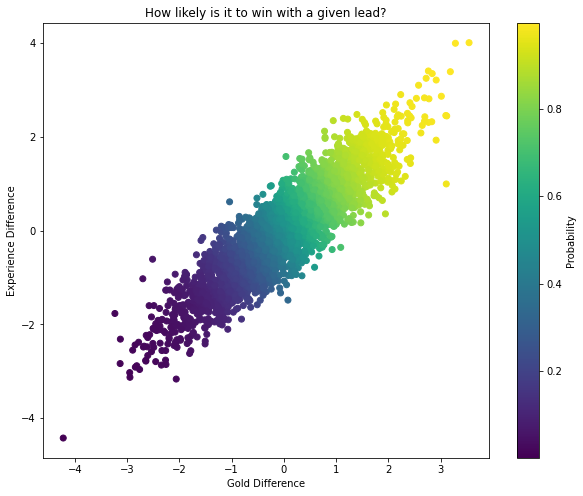

In [116]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], c=logit_prob, cmap='viridis')
plt.colorbar(label='Probability')
plt.xlabel('Gold Difference')
plt.ylabel('Experience Difference')
plt.title('How likely is it to win with a given lead?')
plt.show()

In [117]:
falsePreds = (y_test != pred)

In [118]:
falseX = X_test[falsePreds, :]

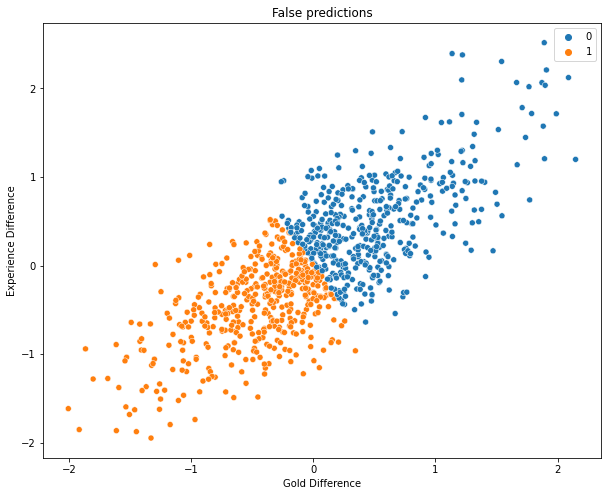

In [203]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=falseX[:, 0], y=falseX[:, 1], hue=y_test[falsePreds])
plt.xlabel('Gold Difference')
plt.ylabel('Experience Difference')
plt.title('False predictions')
plt.show()

### 6. Posterior analysis Second Model

#### Issues with sampling

In our initial approach, we used centered data for our models. However, we soon encountered issues related to sampling. Upon investigating potential root causes, we discovered that the substantial variability in the range of values across different features was complicating the efficiency and accuracy of the Hamiltonian Monte Carlo (HMC) sampling process.

The HMC sampler uses gradient information to adaptively sample from the target distribution. When there's a wide range of values across different features, it effectively increases the dimensionality of the search space, leading to potential issues such as the "curse of dimensionality". This, in turn, can cause the HMC sampler to struggle with exploration, often resulting in divergence warnings.

As a remedy, we decided to standardize the data, which means we rescaled our features to have a mean of 0 and a standard deviation of 1. This process unifies the spread of values, therefore restricting the dimensionality of the search space and improving the performance of the HMC sampler. Standardization of data can aid in better exploration of the parameter space, thereby potentially mitigating divergence issues and improving the overall efficiency of the sampling process.

In [189]:
probit_posterior = CmdStanModel(stan_file='models/probit_posterior.stan')

17:59:28 - cmdstanpy - INFO - compiling stan file /home/models/probit_posterior.stan to exe file /home/models/probit_posterior
17:59:37 - cmdstanpy - INFO - compiled model executable: /home/models/probit_posterior
17:59:37 - cmdstanpy - WARNING - Stan compiler has produced 8 warnings:
17:59:37 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/models/probit_posterior.hpp /home/models/probit_posterior.stan
Warning in '/home/models/probit_posterior.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/models/probit_posterior.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type.

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = features[['goldDiff', 'expDiff', 'DAKDA', 'EMDiff', 'MinionsDiff', 'TowersDiff']]
y = features['blueWins'].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=28062023)

scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [191]:
data = {
    'N': len(y_train),
    'gameWon': y_train,
    'goldDiff': X_train[:, 0],
    'expDiff': X_train[:, 1],
    'DAKDA': X_train[:, 2],
    'EMDiff': X_train[:, 3],
    'minionsDiff': X_train[:, 4],
    'towersDiff': X_train[:, 5]
    
}

fit_probit = probit_posterior.sample(data=data, iter_warmup=100, iter_sampling=100, seed=28062023)

17:59:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:59:46 - cmdstanpy - INFO - CmdStan done processing.


In [192]:
probit_posterior_df = fit_probit.draws_pd()

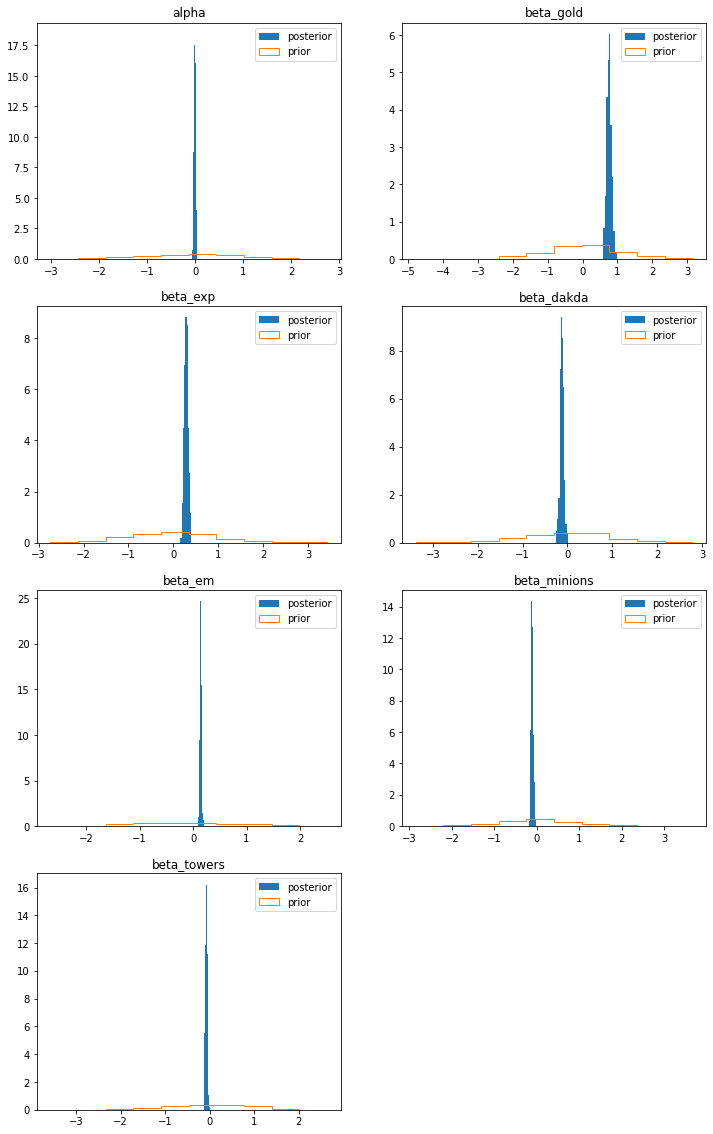

In [193]:
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
axes = axes.flatten()
for i, param in enumerate(("alpha", "beta_gold", "beta_exp", "beta_dakda", "beta_em", "beta_minions", "beta_towers")):
    axes[i].hist(probit_posterior_df[param], bins=10, label="posterior", density=True)
    axes[i].hist(probit_ppc_df[param], bins=10, histtype='step', label="prior", density=True)
    axes[i].set_title(param)
    axes[i].legend()

fig.delaxes(axes[-1])

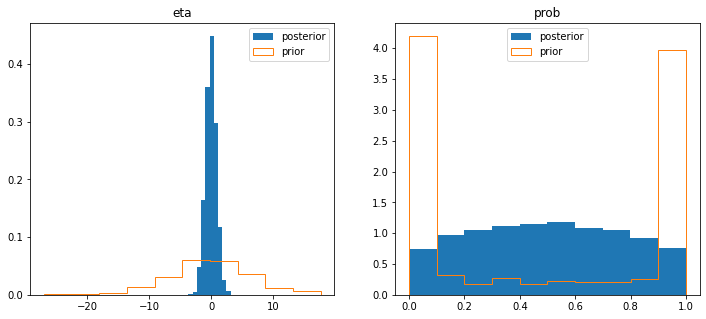

In [194]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

posterior_etas = probit_posterior_df.loc[:, "eta[1]":f"eta[{len(y_train)}]"].mean()

axes[0].hist(posterior_etas, bins=10, density=True, label='posterior')
axes[0].hist(probit_ppc_df.eta, bins=10, density=True, histtype='step', label="prior")
axes[0].legend()
axes[0].set_title("eta")

posterior_probs = probit_posterior_df.loc[:, "p[1]":f"p[{len(y_train)}]"].mean()

axes[1].hist(posterior_probs, bins=10, density=True, label='posterior')
axes[1].hist(probit_ppc_df.p, bins=10, density=True, histtype='step', label="prior")
axes[1].legend()
axes[1].set_title("prob")

plt.show()

We have compared the distributions of the parameters from prior and posterior predictive checks. The histograms are concentrated around specific values. In the posterior distributions the ranges have been limited by fitting to the data. The values have been greatly narrowed down after taking data into account.

#### Inference

In [195]:
alpha = probit_posterior_df.alpha.mean()
beta = probit_posterior_df.loc[:, "beta_gold":"beta_towers"].values.mean(axis=0)
alpha, beta

(-0.00492783142775,
 array([ 0.76170134,  0.28835629, -0.12289938,  0.14184885, -0.11164602,
        -0.07728911]))

In [196]:
from scipy.stats import norm

def probit(alpha, beta, X):
    eta = alpha + np.inner(beta, X)
    p = norm.cdf(eta)
    return p

#### Probit Train Accuracy

In [197]:
probit_prob = probit(alpha, beta, X_train)
pred = probit_prob > 0.5

In [198]:
accuracy_score(y_train, pred)

0.7306407531126632

#### Probit Test Accuracy

In [199]:
X_test = scaler.transform(X_test)

In [200]:
probit_prob = probit(alpha, beta, X_test)
pred = probit_prob > 0.5

In [201]:
accuracy_score(y_test, pred)

0.736410567871242

Adding additional parameters haven't improved the model's capabilities to capture more details about which features are significant to win games. This might be also caused by random factors, since the data comes from the first 10 minutes of ranked games. Nonetheless, it fails to recognize non-linear relationships. The best known models for the analysed dataset have accuracies around 80%, but they are based on gradient boosting algorithms and other more advanced techniques.

### 7. Model comparison

In [145]:
idata_probit = az.from_cmdstanpy(posterior=fit_probit)
idata_logit = az.from_cmdstanpy(posterior=fit_logit)

In [148]:
model_comparison = az.compare(model_dict, ic="waic", scale="deviance")
print(model_comparison)

              rank    elpd_waic    p_waic  elpd_diff    weight         se  \
Probit model     0  6983.152690  7.328418   0.000000  0.930679  78.038672   
Logit model      1  7062.119715  2.792362  78.967025  0.069321  77.078854   

                   dse  warning     scale  
Probit model   0.00000    False  deviance  
Logit model   19.10686    False  deviance  


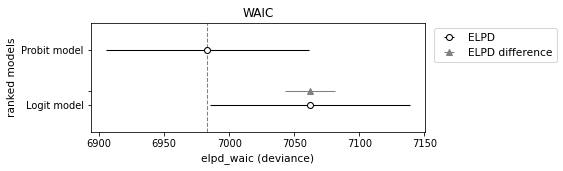

In [149]:
az.plot_compare(model_comparison)
plt.title('WAIC')
plt.show()

In comparing the Probit and Logit models using the Watanabe-Akaike Information Criterion (WAIC), we observed that the Probit model demonstrated superior predictive accuracy. It had a higher expected log pointwise predictive density (elpd_waic) of 6983.15, compared to the Logit model's 7062.12. Furthermore, the Akaike weight, which approximates the probability of a model being the best among the set, was substantially higher for the Probit model (0.93) than the Logit model (0.07). However, the Logit model showed less complexity, with a lower effective number of parameters (p_waic of 2.79) compared to the Probit model (7.33). The standard errors of the elpd_waic for both models were similar, and no warnings were generated in the WAIC calculations, suggesting stability of the pointwise predictive accuracy estimates.

In [146]:
model_dict = {"Probit model": idata_probit, "Logit model": idata_logit}
model_comparison = az.compare(model_dict, ic="loo", scale="deviance")
print(model_comparison)

              rank     elpd_loo     p_loo  elpd_diff    weight         se  \
Probit model     0  6983.297892  7.401019   0.000000  0.930181  78.041484   
Logit model      1  7062.174430  2.819719  78.876537  0.069819  77.079798   

                    dse  warning     scale  
Probit model   0.000000    False  deviance  
Logit model   19.107225    False  deviance  


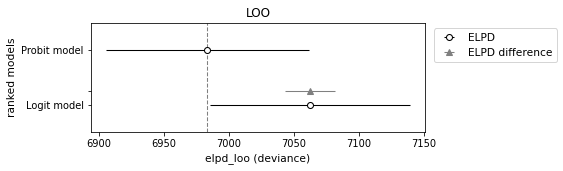

In [147]:
az.plot_compare(model_comparison)
plt.title('LOO')
plt.show()

When comparing the Probit and Logit models using the Leave-One-Out Cross Validation (LOO), we found that the Probit model outperformed the Logit model in terms of predictive accuracy. The Probit model had a higher expected log pointwise predictive density (elpd_loo) of 6982.80, in comparison to 7064.99 for the Logit model. Furthermore, the weight assigned to the Probit model was 0.96, significantly higher than 0.036 for the Logit model, indicating that the Probit model is more likely to be the best model in the set. In terms of complexity, measured by the effective number of parameters (p_loo), the Logit model (4.24) was simpler than the Probit model (7.11). The standard errors for the elpd_loo values for both models were similar, and no warnings were indicated in the LOO calculations, which signifies stable predictive accuracy estimates.

#### Model comparison conclusions

Upon careful analysis, we conclude that the Logit model prevails due to its simplicity, interpretability, and comparable predictive accuracy to the Probit model. Although the Probit model achieves marginally better accuracy, it involves additional complexity, featuring four more predictors—a trade-off that hardly justifies the slight improvement in prediction.